# Exercise 3

In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.integrate import simps
from scipy.signal import gaussian
import matplotlib.pyplot as plt
from numba import jit

In [2]:
def MakeRandL(K, dt, dz, kw, n):
    alpha = dt/(2 * dz**2)
    Kp = K[2:] - K[:-2]
    gamma = 2 * alpha*kw*dz* (1 - ((-3/2)*K[0] + 2*K[1]- 0.5*K[2])/(2*K[0]))
    
    sub_diag = np.ones(n-1)
    main_diag = np.ones(n)
    super_diag = np.ones(n-1)
    
    sub_diag[-1] = 2*alpha*K[-1]
    sub_diag[:-1] = -(alpha/4)*Kp + alpha*K[1:-1]
    
    main_diag[0] = 2*alpha*K[0] + gamma
    main_diag[1:] = 2*alpha*K[1:]
    
    super_diag[0] = 2*alpha*K[0]
    super_diag[1:] = (alpha/4)*Kp + alpha*K[1:-1]
    L = diags((-sub_diag, 1+main_diag, -super_diag), offsets = (-1, 0, 1))
    R = diags((sub_diag, 1-main_diag, super_diag), offsets = (-1, 0, 1))
    return L,R,gamma





def SolveSystem(K, C0, dt, dz, kw, Ceq , n, Nt):
    L,R, gamma =  MakeRandL(K, dt, dz, kw,n)
    # Insert initial values
    C = C0.copy()    #To not overwrite the C0
    S = 2*gamma*Ceq
    # Loop over time
    for i in range(1, Nt+1):
        # First, calculate matrix-vector product on right-hand side
        V = R.dot(C)
        V[0] += 0.5*(S[i-1]+S[i])
        # Then, solve equation system on left-hand side
        C = tdma(L, V)
    return C

   
def SolveSystemTime(K, C0, dt, dz, kw, Ceq , n, Nt):
    L,R, gamma =  MakeRandL(K, dt, dz, kw,n)
   # print(R)
    # Array to hold solution at all times
    C = np.zeros((Nt+1, n))
    # Insert initial values
    C[0] = C0.copy()   #To not overwrite the C0
    S = 2*gamma*Ceq
    
    # Loop over time

    for i in range(1, Nt+1):
        # First, calculate matrix-vector product on right-hand side
        V = R.dot(C[i-1])
        V[0] += 0.5*(S[i-1]+S[i])
        # Then, solve equation system on left-hand side
        C[i,:] = tdma(L, V)
    return C

In [3]:
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    # Make to extra arrays to avoid overwriting input
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        q = (b[i] - a[i-1]*c_[i-1])
        c_[i] = c[i]/q
        d_[i] = (d[i] - a[i-1]*d_[i-1])/q
    d_[N-1] = (d[N-1] - a[N-2]*d_[N-2])/(b[N-1] - a[N-2]*c_[N-2])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse array structure into separate diagonals,
    # and passes them to the numba-compiled solver defined above.
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

In [4]:
n = 100000
Nt = 1000

L = 100
Z, dz = np.linspace(0, L, n, retstep = True)
t = 1.2E7
time, dt = np.linspace(0,t, Nt+1, retstep = True)

# Parameters from problem 2
K_ref = 1E-3 + 2E-2*(Z/7)*np.exp(-Z/7) + 5E-2*((L-Z)/10)*np.exp(-(L-Z)/10)
Ceq_ref = 5060*415E-6*np.ones(Nt+1)

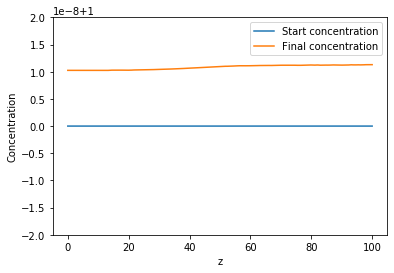

In [5]:
#Test case 1


# Diffusivity from problem 2
C0 = np.ones(n)
kw = 0

C = SolveSystem(K_ref, C0, dt, dz, kw, Ceq_ref, n, Nt)

plt.ylim(1-2E-8,1+2E-8)
plt.plot(Z, C0,label = 'Start concentration')
plt.plot(Z, C,label = 'Final concentration')
plt.xlabel('z')
plt.ylabel('Concentration')
plt.legend()
plt.savefig(f'E3Testcase1.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

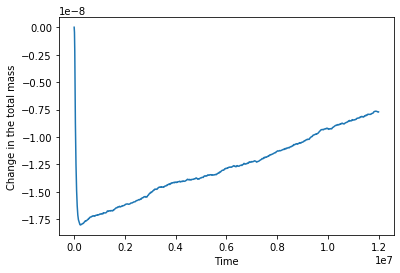

In [6]:
#Test case 2

C0 = gaussian(n, std=1000)

kw = 0



C = SolveSystemTime(K_ref, C0, dt, dz, kw,Ceq_ref, n, Nt)

mass = simps(C,x=Z)

plt.plot(time, (mass-mass[0])/mass[0])
plt.xlabel('Time')
plt.ylabel('Change in the total mass')
plt.savefig(f'E3Testcase2.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

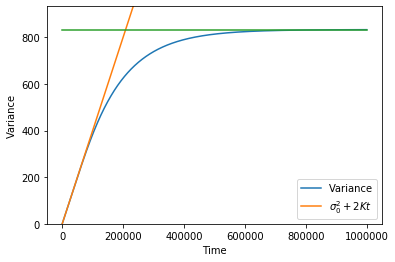

In [7]:
#Test case 3
tv = 1E6
timev, dtv = np.linspace(0,tv, Nt+1, retstep = True)

kw = 0

K = 2E-3*np.ones(n)
C0 = gaussian(n, std=1000)

C = SolveSystemTime(K, C0, dtv, dz, kw, Ceq_ref, n, Nt)

M = simps(C,x=Z)
mu = simps(C*Z,x=Z)/M

var = np.zeros_like(mu)
for i in range(Nt+1):
    var[i] = simps(C[i]*(Z-mu[i])**2,x=Z)/M[i]

    
plt.ylim(0,max(var)+100)
plt.plot(timev,var, label = 'Variance')
plt.plot(timev[:int(Nt/2)],var[0]**2 + 2*K[0]*timev[:int(Nt/2)],label = '$\sigma^2_0 + 2Kt$')
plt.plot(timev,max(var)*np.ones_like(timev))
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.savefig(f'E3Testcase3.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

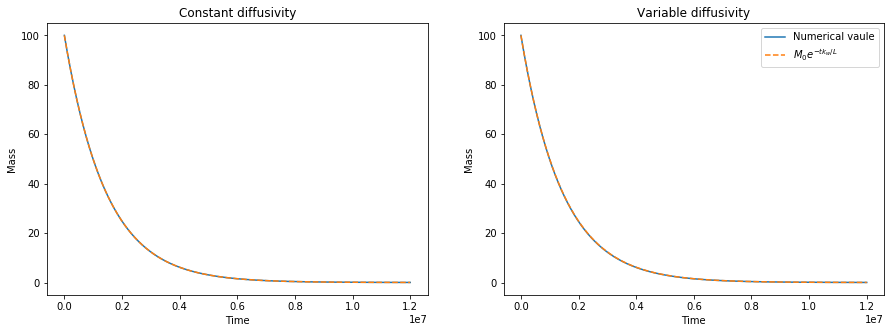

In [8]:
# Test case 4

Ceq = np.zeros(Nt+1)
kw = 6.97*1E-5
tau = L/kw

K = K_ref[0]*1E5*np.ones(n)
C0 = np.ones(n)

Cc = SolveSystemTime(K, C0, dt, dz, kw,Ceq, n, Nt)
Mc = simps(Cc,x=Z)


#From problem 2
K = K_ref*1E5
Cv = SolveSystemTime(K, C0, dt, dz, kw,Ceq, n, Nt)
Mv = simps(Cv,x=Z,axis = 1)

fig, axes = plt.subplots(ncols = 2, figsize = (15,5))
axes[0].set_title('Constant diffusivity')
axes[1].set_title('Variable diffusivity')
axes[0].plot(time,Mc,label = 'Numerical vaule')
axes[0].plot(time,Mc[0]*np.exp(-time/tau),'--',label = '$M_0 e^{-tk_w/L}$')
axes[1].plot(time,Mv,label = 'Numerical vaule')
axes[1].plot(time,Mv[0]*np.exp(-time/tau),'--',label = '$M_0 e^{-tk_w/L}$')
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[0].set_ylabel('Mass')
axes[1].set_ylabel('Mass')
plt.legend()
plt.savefig(f'E3Testcase4.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

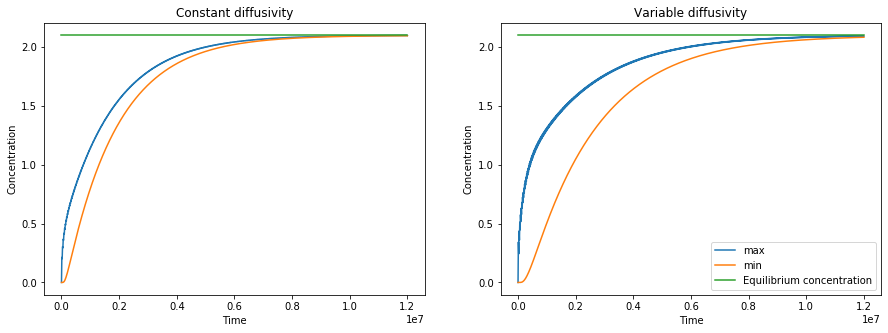

In [9]:
# Test case 5

kw = 6.97*1E-5
C0 = np.zeros(n)

K = K_ref[0]*1E1*np.ones(n)
Cc = SolveSystemTime(K, C0, dt, dz, kw,Ceq_ref, n, Nt)


# Diffusivity from problem 2
K = 1E-3 + 2E-2*(Z/7)*np.exp(-Z/7) + 5E-2*((L-Z)/10)*np.exp(-(L-Z)/10)
Cv = SolveSystemTime(K_ref, C0, dt, dz, kw,Ceq_ref, n, Nt)

fig, axes = plt.subplots(ncols = 2, figsize = (15,5))
axes[0].set_title('Constant diffusivity')
axes[1].set_title('Variable diffusivity')


axes[0].plot(time,np.max(Cc,axis = 1),label = 'max')
axes[0].plot(time,np.min(Cc,axis = 1),label = 'min')
axes[1].plot(time,np.max(Cv,axis = 1),label = 'max')
axes[1].plot(time,np.min(Cv,axis = 1),label = 'min')
axes[0].plot(time,Ceq_ref, label = 'Equilibrium concentration')
axes[1].plot(time,Ceq_ref, label = 'Equilibrium concentration')
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[0].set_ylabel('Concentration')
axes[1].set_ylabel('Concentration')
plt.legend()
plt.savefig(f'E3Testcase5.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

# Problem 2

In [10]:
L = 100
Tmax = 10*24*3600
kw = 6.97*1E-5


def K(z):
    return 1E-3 + 2E-2*(z/7)*np.exp(-z/7) + 5E-2*((L-z)/10)*np.exp(-(L-z)/10)

In [11]:
#Convergence test for dt
dt_ref = 1E-3 *3600

n_ref  = 2001
Z_ref, dz_ref = np.linspace(0, L, n_ref, retstep = True)
C0 = np.zeros(n_ref)

Ceq = 5060 * 415E-6 *np.ones(int(Tmax/dt_ref)+1)
C_ref = SolveSystem(K(Z_ref), C0, dt_ref, dz_ref, kw,Ceq, n_ref, int(Tmax/dt_ref))
M1_ref = simps(C_ref*Z_ref, x = Z_ref)
M2_ref = simps(C_ref*Z_ref**2, x = Z_ref)
norm = np.linalg.norm(C_ref)
t_norm = np.linalg.norm(C_ref, ord=2)

In [12]:
timesteps = np.array([2E-3,5E-3,0.01,0.02,0.05,0.1,0.2,0.5,1,2,4,12,24,48] )*3600

M1_TimeError = np.zeros(len(timesteps))
M2_TimeError = np.zeros(len(timesteps))
RMS_TimeError = np.zeros(len(timesteps))
L2_TimeError = np.zeros(len(timesteps))
C0 = np.zeros(n_ref)

for i, dt in enumerate(timesteps):
    Nt = int(Tmax/dt)
    Ceq = 5060 * 415E-6 * np.ones(Nt+1)
    C = SolveSystem(K(Z_ref), C0, dt, dz_ref, kw,Ceq, n_ref, Nt)
    M1_TimeError[i] = np.abs(M1_ref - simps(C*Z_ref, x = Z_ref))/M1_ref
    M2_TimeError[i] = np.abs(M2_ref - simps(C*Z_ref**2, x = Z_ref))/M2_ref
    RMS_TimeError[i] = (np.sqrt(np.mean(((C_ref-C))**2)))/norm
    L2_TimeError[i] = np.linalg.norm(C_ref-C, ord=2)/t_norm

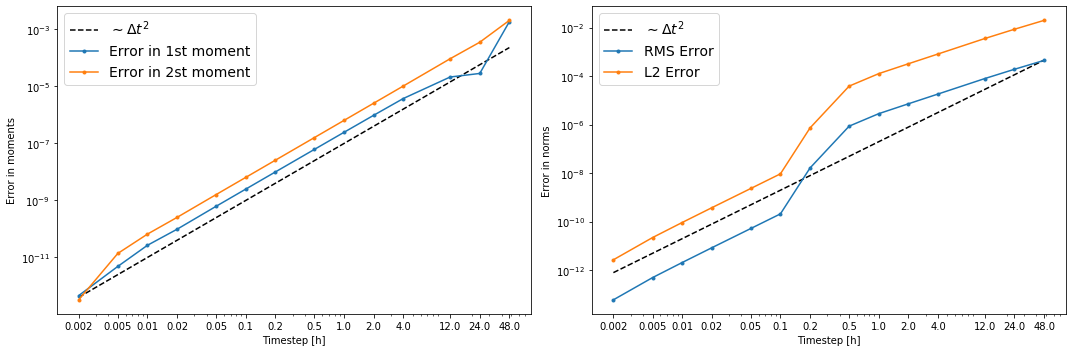

In [13]:
# Plot results
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

htimesteps = timesteps/3600
ax[0].plot(htimesteps, 1E-7*htimesteps**2, '--', c = 'k', label = '$\sim \Delta t^2$')
ax[0].plot(htimesteps, M1_TimeError, marker = '.',label = 'Error in 1st moment')
ax[0].plot(htimesteps, M2_TimeError, marker = '.',label = 'Error in 2st moment')
ax[0].set_ylabel('Error in moments')

ax[1].plot(htimesteps, 2E-7*htimesteps**2, '--', c = 'k', label = '$\sim \Delta t^2$')
ax[1].plot(htimesteps, RMS_TimeError, marker = '.',label = 'RMS Error')
ax[1].plot(htimesteps, L2_TimeError, marker = '.',label = 'L2 Error')
ax[1].set_ylabel('Error in norms')


for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(fontsize = 14)
    a.set_xticks(htimesteps)
    a.set_xticklabels(htimesteps)
    a.set_xlabel('Timestep [h]')

    
plt.savefig(f'E3P2dt.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()

In [14]:
#Convergence test for dz
dt_ref = 1E-2 * 3600

n_ref  = 20001
Z_ref, dz_ref = np.linspace(0, L, n_ref, retstep = True)
C0 = np.zeros(n_ref)

Ceq = 5060 * 415E-6 *np.ones(int(Tmax/dt_ref)+1)
C_ref = SolveSystem(K(Z_ref), C0, dt_ref, dz_ref, kw,Ceq, n_ref, int(Tmax/dt_ref))
M1_ref = simps(C_ref*Z_ref, x = Z_ref)
M2_ref = simps(C_ref*Z_ref**2, x = Z_ref)
norm = np.linalg.norm(C_ref)
t_norm = np.linalg.norm(C_ref, ord=2)

In [15]:
Nt = int(Tmax/dt_ref)
cellnumbers = np.array([101,201,501,1001,2001,5001,10001])


M1_gridError = np.zeros(len(cellnumbers))
M2_gridError = np.zeros(len(cellnumbers))
RMS_gridError = np.zeros(len(cellnumbers))
L2_gridError = np.zeros(len(cellnumbers))

for i, n in enumerate(cellnumbers):
    C0 = np.zeros(n)
    Z, dz = np.linspace(0, L, n, retstep = True)
    nskip = int((n_ref-1)/(n-1))
    C = SolveSystem(K(Z), C0, dt_ref, dz, kw,Ceq, n, int(Tmax/dt_ref))
    M1_gridError[i] = np.abs(M1_ref - simps(C*Z, x = Z))/M1_ref
    M2_gridError[i] = np.abs(M2_ref - simps(C*Z**2, x = Z))/M2_ref
    RMS_gridError[i] = (np.sqrt(np.mean(((C_ref[::nskip]-C))**2)))/norm
    L2_gridError[i] = np.linalg.norm(C_ref[::nskip]-C, ord=2)/t_norm

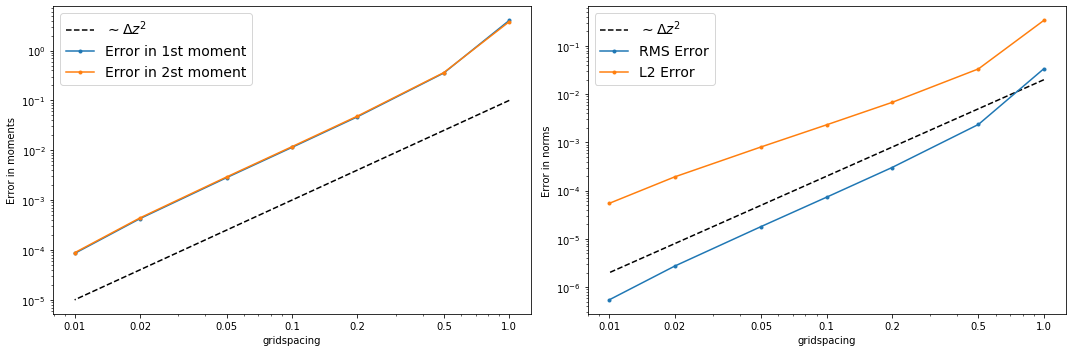

In [16]:
# Plot results
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
gridspacing = L/(cellnumbers-1)

ax[0].plot(gridspacing, 1E-1*gridspacing**2, '--', c = 'k', label = '$\sim \Delta z^2$')
ax[0].plot(gridspacing, M1_gridError, marker = '.',label = 'Error in 1st moment')
ax[0].plot(gridspacing, M2_gridError, marker = '.',label = 'Error in 2st moment')
ax[0].set_ylabel('Error in moments')

ax[1].plot(gridspacing, 2E-2*gridspacing**2, '--', c = 'k', label = '$\sim \Delta z^2$')
ax[1].plot(gridspacing, RMS_gridError, marker = '.',label = 'RMS Error')
ax[1].plot(gridspacing, L2_gridError, marker = '.',label = 'L2 Error')
ax[1].set_ylabel('Error in norms')


for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(fontsize = 14)
    a.set_xticks(gridspacing)
    a.set_xticklabels(gridspacing)
    a.set_xlabel('gridspacing')
 
plt.savefig(f'E3P2dz.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()

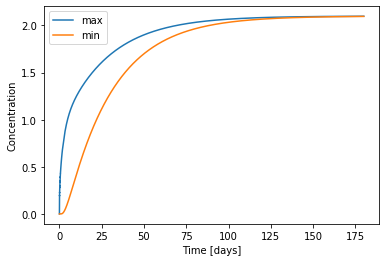

In [17]:
#Running for 180 days
dt = 0.1*3600
dz = 0.05
Tmax = 180*24*3600
L = 100

kw = 6.97*1E-5
C0 = np.zeros(int(L/dz))
Ceq = 5060 * 415E-6 *np.ones(int(Tmax/dt)+1)
Z = np.arange(0,L,dz)
time, dt = np.linspace(0,Tmax, int(Tmax/dt)+1, retstep = True)

C = SolveSystemTime(K(Z), C0, dt, dz, kw,Ceq, int(L/dz), int(Tmax/dt))
days = time/(24*3600)
plt.plot(days,np.max(C,axis = 1),label = 'max')
plt.plot(days,np.min(C,axis = 1),label = 'min')
plt.xlabel('Time [days]')
plt.ylabel('Concentration')
plt.legend()
plt.savefig(f'E3P2a.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

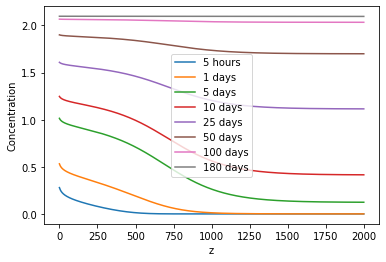

In [18]:
#get the index of the times to plot
T = np.array([5,24,5*24,10*24,25*24,50*24,100*24,180*24])/0.1

for t in T:
    if (t*0.1)//(24):
        plt.plot(C[int(t)],label = f'{t*0.1/(24):.0f} days')
    else:
        plt.plot(C[int(t)],label = f'{t*0.1:.0f} hours')

plt.xlabel('z')
plt.ylabel('Concentration')
plt.legend()
plt.savefig(f'E3P2b.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

## Problem 3

In [19]:
Tmax = 364*24*3600
L = 4000

def K(z):
    return 1E-2 +(1E-4-1E-2)/(1+np.exp(-0.5*(z-100)))

def Ceq(t):
    return 5060 * (415 + 2.3*t/(365*24*3600))*1E-6

kw = 6.97*1E-5
#Equlibrium with the present atmosphere
C0v = 5060 * 415E-6

In [20]:
#Convergence test for dt
dt_ref = 0.1*3600
time_ref = np.linspace(0,Tmax,int(Tmax/dt_ref)+1)

n_ref  = 40001
Z_ref, dz_ref = np.linspace(0, L, n_ref, retstep = True)
C0 = C0v*np.ones(n_ref)


C_ref = SolveSystem(K(Z_ref), C0, dt_ref, dz_ref, kw,Ceq(time_ref), n_ref, int(Tmax/dt_ref))
M1_ref = simps(C_ref*Z_ref, x = Z_ref)
M2_ref = simps(C_ref*Z_ref**2, x = Z_ref)
norm = np.linalg.norm(C_ref)
t_norm = np.linalg.norm(C_ref, ord=2)

In [21]:
timesteps = np.array([0.5,1,2,4,8,14,24,48,4*24,7*24,13*24,28*24,52*24])*3600

M1_TimeError = np.zeros(len(timesteps))
M2_TimeError = np.zeros(len(timesteps))
RMS_TimeError = np.zeros(len(timesteps))
L2_TimeError = np.zeros(len(timesteps))


for i, dt in enumerate(timesteps):
    time = np.linspace(0,Tmax,int(Tmax/dt)+1)
    C = SolveSystem(K(Z_ref), C0, dt, dz_ref, kw,Ceq(time), n_ref, int(Tmax/dt))
    M1_TimeError[i] = np.abs(M1_ref - simps(C*Z_ref, x = Z_ref))/M1_ref
    M2_TimeError[i] = np.abs(M2_ref - simps(C*Z_ref**2, x = Z_ref))/M2_ref
    RMS_TimeError[i] = (np.sqrt(np.mean(((C_ref-C))**2)))/norm
    L2_TimeError[i] = np.linalg.norm(C_ref-C, ord=2)/t_norm

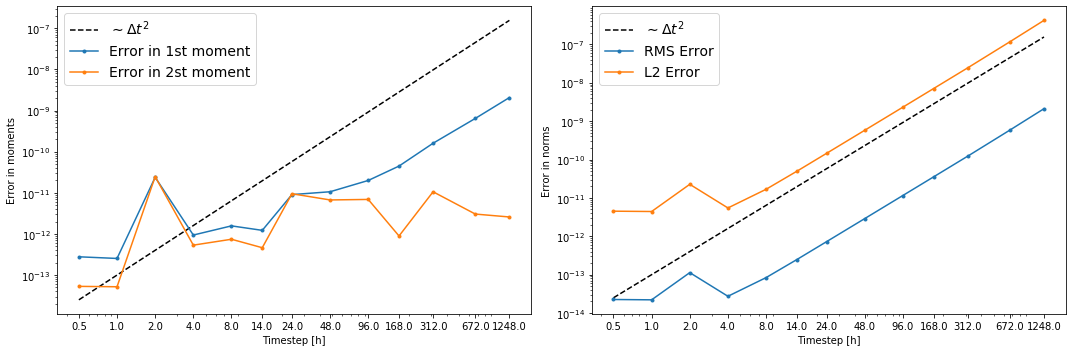

In [22]:
# Plot results
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))

htimesteps = timesteps/(3600)
ax[0].plot(htimesteps, 1E-13*htimesteps**2, '--', c = 'k', label = '$\sim \Delta t^2$')
ax[0].plot(htimesteps, M1_TimeError, marker = '.',label = 'Error in 1st moment')
ax[0].plot(htimesteps, M2_TimeError, marker = '.',label = 'Error in 2st moment')
ax[0].set_ylabel('Error in moments')

ax[1].plot(htimesteps, 1E-13*htimesteps**2, '--', c = 'k', label = '$\sim \Delta t^2$')
ax[1].plot(htimesteps, RMS_TimeError, marker = '.',label = 'RMS Error')
ax[1].plot(htimesteps, L2_TimeError, marker = '.',label = 'L2 Error')
ax[1].set_ylabel('Error in norms')


for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(fontsize = 14)
    a.set_xticks(htimesteps)
    a.set_xticklabels(htimesteps)
    a.set_xlabel('Timestep [h]')
 
plt.savefig(f'E3P3dt.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()

In [23]:
#Convergence test for dz
dt_ref = 8*3600
time_ref = np.linspace(0,Tmax,int(Tmax/dt_ref)+1)

n_ref  = 400001
Z_ref, dz_ref = np.linspace(0, L, n_ref, retstep = True)
C0 = C0v*np.ones(n_ref)


C_ref = SolveSystem(K(Z_ref), C0, dt_ref, dz_ref, kw,Ceq(time_ref), n_ref, int(Tmax/dt_ref))
M1_ref = simps(C_ref*Z_ref, x = Z_ref)
M2_ref = simps(C_ref*Z_ref**2, x = Z_ref)
norm = np.linalg.norm(C_ref)
t_norm = np.linalg.norm(C_ref, ord=2)

In [24]:
cellnumbers = np.array([1001, 2001, 4001,10001,20001,40001,100001,200001])

M1_gridError = np.zeros(len(cellnumbers))
M2_gridError = np.zeros(len(cellnumbers))
RMS_gridError = np.zeros(len(cellnumbers))
L2_gridError = np.zeros(len(cellnumbers))

for i, n in enumerate(cellnumbers):
    Z, dz = np.linspace(0, L, n, retstep = True)
    C0 = C0v*np.ones(n)
    nskip = int((n_ref-1)/(n-1))
    C = SolveSystem(K(Z), C0, dt_ref, dz, kw,Ceq(time_ref), n, int(Tmax/dt_ref))
    M1_gridError[i] = np.abs(M1_ref - simps(C*Z, x = Z))/M1_ref
    M2_gridError[i] = np.abs(M2_ref - simps(C*Z**2, x = Z))/M2_ref
    RMS_gridError[i] = (np.sqrt(np.mean(((C_ref[::nskip]-C))**2)))/norm
    L2_gridError[i] = np.linalg.norm(C_ref[::nskip]-C, ord=2)/t_norm

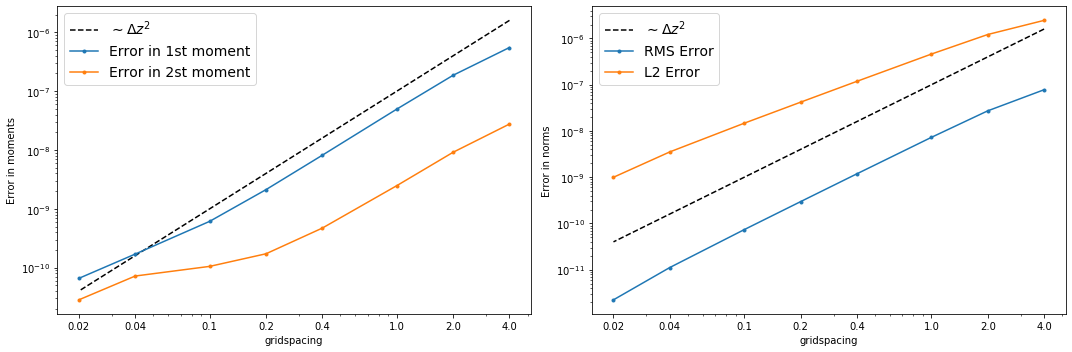

In [25]:
# Plot results
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
gridspacing = L/(cellnumbers-1)
ax[0].plot(gridspacing, 1E-7*gridspacing**2, '--', c = 'k', label = '$\sim \Delta z^2$')
ax[0].plot(gridspacing, M1_gridError, marker = '.',label = 'Error in 1st moment')
ax[0].plot(gridspacing, M2_gridError, marker = '.',label = 'Error in 2st moment')
ax[0].set_ylabel('Error in moments')

ax[1].plot(gridspacing, 1E-7*gridspacing**2, '--', c = 'k', label = '$\sim \Delta z^2$')
ax[1].plot(gridspacing, RMS_gridError, marker = '.',label = 'RMS Error')
ax[1].plot(gridspacing, L2_gridError, marker = '.',label = 'L2 Error')
ax[1].set_ylabel('Error in norms')


for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(fontsize = 14)
    a.set_xticks(gridspacing)
    a.set_xticklabels(gridspacing)
    a.set_xlabel('gridspacing')
 
plt.savefig(f'E3P3dz.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()

In [26]:
dt = 24*3600
dz = 0.4
Tmax = 10*365*24*3600
L = 4000
n = int(L/dz)

kw = 6.97*1E-5
C0 = C0v*np.ones(n)
Z = np.arange(0,L,dz)
time, dt = np.linspace(0,Tmax, int(Tmax/dt)+1, retstep = True)

C = SolveSystemTime(K(Z), C0, dt, dz, kw,Ceq(time), n, int(Tmax/dt))

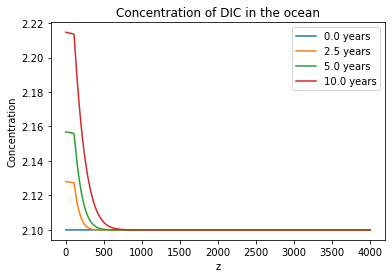

In [27]:
#get the index of the times to plot
T = np.array([0,2.5,5,10])*365*24*3600/dt

for t in T:
    plt.plot(Z,C[int(t)],label = f'{t*dt/(365*24*3600):.1f} years')
plt.title('Concentration of DIC in the ocean')
plt.xlabel('z')
plt.ylabel('Concentration')
plt.legend()
plt.savefig(f'E3P3a.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

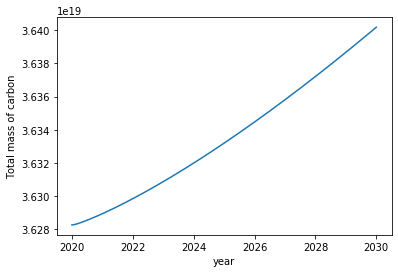

In [28]:
#Total mass
mass = simps(C,x=Z)
years = 2020 + time/(365*24*3600)
plt.plot(years,mass*12*360E12)
plt.ylabel('Total mass of carbon')
plt.xlabel('year')
plt.savefig(f'E3P3b.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
average = 12*360E12*(mass[-1]-mass[0])/10
print(f'{average:.3e}')

1.191e+16
